In [1]:
import sys
sys.path.insert(1, "/home/vincent/Documenten/BachelorsProject/GitHub_Repo/")
import rijks_torch.learning_problems as lp
import rijks_torch.learning_problems.defaults as defs
from rijks_torch.data_loading import RijksDataloaders

import numpy as np
import torch
from torchvision import transforms
import matplotlib.pyplot as plt
import pandas as pd
from copy import deepcopy

In [2]:
# Make sure model architecture corresponds to state_dict file (.pth)
getmodel_fun = lp.get_swin_b_problem
state_dict_file = "/home/vincent/Documenten/BachelorsProject/best_models/ots_type2_swin_b-best.pth"

# Make sure dataset corresponds to used model!
dataset_path = "/home/vincent/Documenten/BachelorsProject/Rijksdata/type/fullsize2"
jpg_path = "/home/vincent/Documenten/BachelorsProject/Rijksdata/jpg/"

In [3]:
# Getting dataset and model:
datloader = RijksDataloaders(
    ds_name=dataset_path,
    hist_path=dataset_path + "-hist.csv",
    img_dir=jpg_path,
    transforms={"all": defs.buildTransform(imnet_norm=True)},
    batch_size=2
)

model, dl = getmodel_fun(off_the_shelf=False, pretrained=False, dl=datloader)
model.load_state_dict(torch.load(state_dict_file, map_location=torch.device('cpu')))
model = model.eval()

/home/vincent/.local/lib/python3.10/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [4]:
def getAllAttentionWeights(model, image):
    """ Getting all attention weights by adding forward hooks and feeding it an image """
    att_weighs = []

    # Don't know how to remove the hooks again, so doing it this way :-p
    model_copy = deepcopy(model)

    def add_to_att_weights(module, inp, outp):
        nonlocal att_weighs
        # Taking the mean of all attention heads, but could also be max or min
        att_weighs += [outp.detach().numpy()]
    
    for name, module in model_copy.named_modules():
        if "attn_drop" in name: # A timm thing. This only works for timm models ;-)
            module.register_forward_hook(add_to_att_weights)
    
    model_copy(image)
    
    return att_weighs

In [19]:
iterator = iter(dl.test)

In [35]:
img = next(iterator)[0][0]

In [36]:
x = getAllAttentionWeights(model, img.unsqueeze(0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


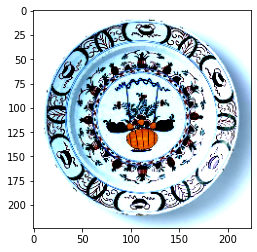

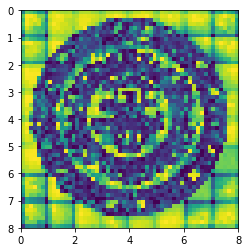

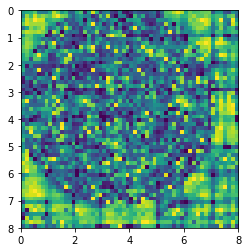

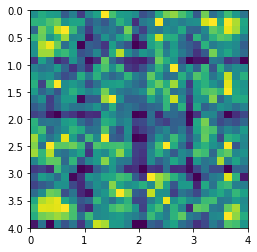

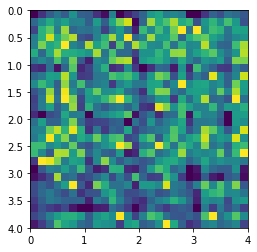

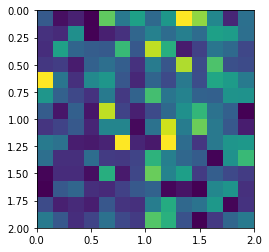

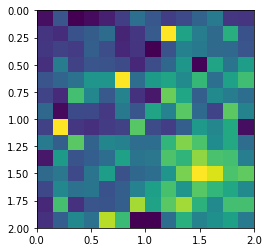

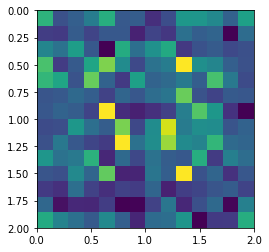

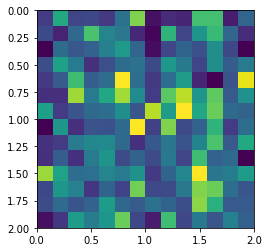

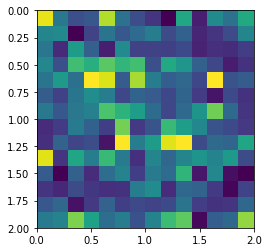

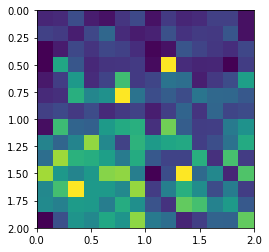

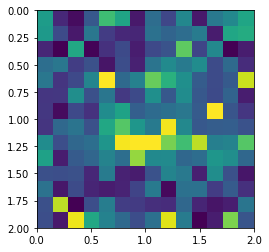

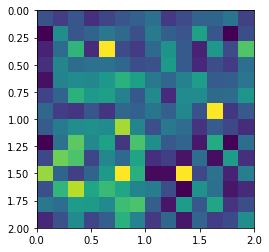

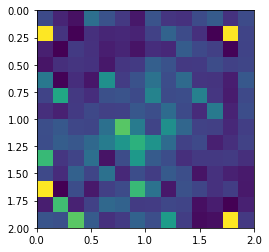

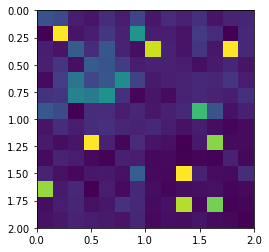

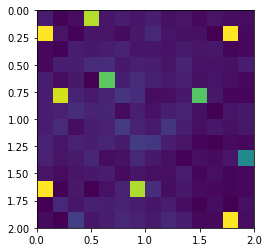

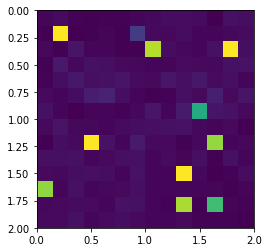

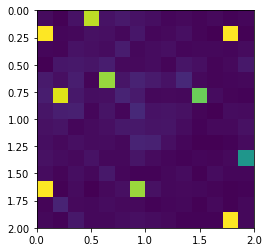

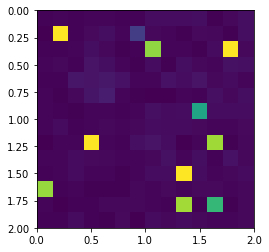

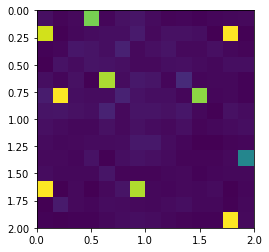

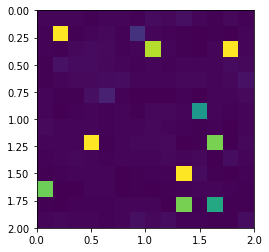

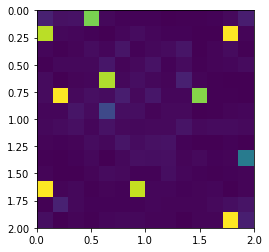

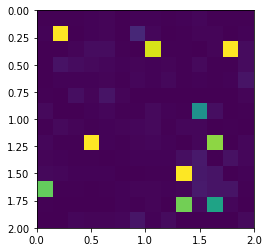

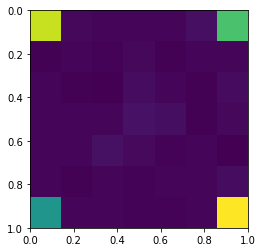

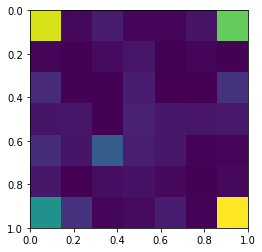

In [38]:
def meanAttentionPerLayerTest(att_mat):
    
    sqrt_windows = int(np.sqrt(len(att_mat)))
    
    for idx, s in enumerate(att_mat):
        row = int(idx / sqrt_windows)
        col = int(idx % sqrt_windows)

        s_new = np.mean(s, axis=(0,1))
        s_new = np.reshape(s_new, (7,7))
        plt.imshow(s_new, extent=(col, col+1, row+1, row))
    plt.ylim(bottom=sqrt_windows, top=0)
    plt.xlim(left=0, right=sqrt_windows)
    plt.show()

plt.imshow(img.detach().numpy().transpose(1,2,0))
plt.show()

for layer in x:
    meanAttentionPerLayerTest(layer)

In [7]:
model

# for layer in model.layers:
#     for idx, block in enumerate(layer.blocks):
#         print(f"block_{idx}: {int(224 / block.input_resolution[0])} - head: {block.num_heads}")

SwinTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
    (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (layers): Sequential(
    (0): BasicLayer(
      dim=128, input_resolution=(56, 56), depth=2
      (blocks): ModuleList(
        (0): SwinTransformerBlock(
          (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (attn): WindowAttention(
            (qkv): Linear(in_features=128, out_features=384, bias=True)
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=128, out_features=128, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
            (softmax): Softmax(dim=-1)
          )
          (drop_path): Identity()
          (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=128, out_features=512, bias=True)
     